In [1]:
from stravalib.client import Client
TOKEN = "#####"
client = Client(access_token = TOKEN)
activities = client.get_activities(limit=20000)
activities

<BatchedResultsIterator entity=Activity>

In [2]:
init_cols = ['average_heartrate', 'max_heartrate', 'suffer_score','distance','moving_time', 'type','start_date_local', 'has_heartrate']
data = []
for activity in activities:
    temp = activity.to_dict()
    data.append([temp.get(x) for x in init_cols])
    
import pandas as pd
df = pd.DataFrame(data, columns=init_cols)
df.head()

,average_heartrate,max_heartrate,suffer_score,distance,moving_time,type,start_date_local,has_heartrate
0,144.9,169.0,19.0,9675.8,0:49:36,Run,2019-05-30T07:24:33,True
1,139.6,157.0,10.0,6454.5,0:35:19,Run,2019-05-28T20:19:00,True
2,162.4,180.0,259.0,42186.8,3:05:18,Run,2019-05-26T06:30:28,True
3,123.7,143.0,2.0,3036.6,0:14:24,Run,2019-05-25T18:05:30,True
4,131.7,150.0,7.0,5897.2,0:33:57,Run,2019-05-23T17:09:42,True


In [3]:
def get_minutes(time_str):
    h, m, s = time_str.split(':')
    return 60*int(h)+int(m)+int(s)/60.0

df = df[df['has_heartrate'].isin([True])]
df['distance_mile'] = df['distance'] * 0.000621371
df['time_min'] = df['moving_time'].apply(get_minutes)
df['average_pace'] = df['time_min']/df['distance_mile']
df['start_date_local'] = pd.to_datetime(df['start_date_local'])
df.set_index('start_date_local', inplace=True)
df.head()


,average_heartrate,max_heartrate,suffer_score,distance,moving_time,type,has_heartrate,distance_mile,time_min,average_pace
start_date_local,,,,,,,,,,
2019-05-30 07:24:33,144.9,169.0,19.0,9675.8,0:49:36,Run,True,6.012262,49.600000,8.249807
2019-05-28 20:19:00,139.6,157.0,10.0,6454.5,0:35:19,Run,True,4.010639,35.316667,8.805745
2019-05-26 06:30:28,162.4,180.0,259.0,42186.8,3:05:18,Run,True,26.213654,185.300000,7.068835
2019-05-25 18:05:30,123.7,143.0,2.0,3036.6,0:14:24,Run,True,1.886855,14.400000,7.631746
2019-05-23 17:09:42,131.7,150.0,7.0,5897.2,0:33:57,Run,True,3.664349,33.950000,9.264947


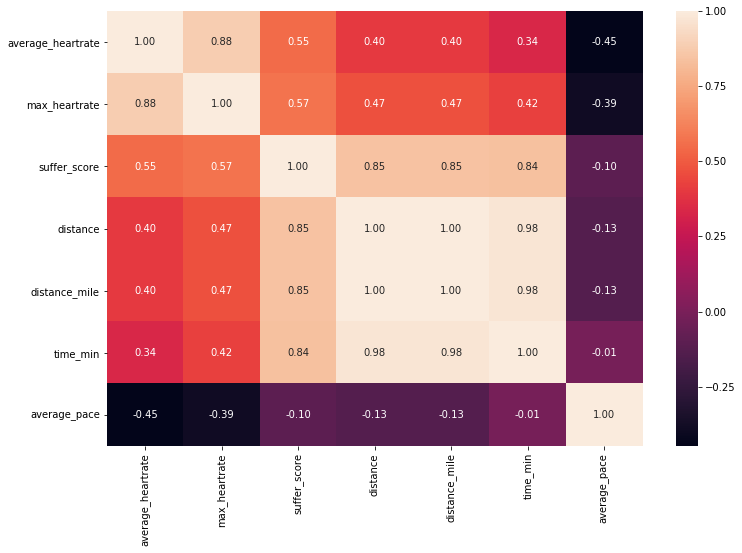

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-dark-palette')

del df['has_heartrate']
corr = df.corr()

plt.figure(figsize = (12, 8))
sns.heatmap(corr, annot=True, fmt=".2f")

In [5]:
import numpy as np

def f(group):
    return (group-group.mean()).abs().div(group.std())

grouped = df.groupby('type')
outliers = grouped.transform(f) > 3
df = df[~outliers.any(axis=1)]
df = df[df['average_pace'] != np.inf]

trends = df.copy()
trends.set_index(pd.to_datetime(trends.index), drop=True, inplace = True)
trends['weekday'] = trends.index.map(lambda x: x.weekday)
trends.groupby('weekday').mean()

,average_heartrate,max_heartrate,suffer_score,distance,distance_mile,time_min,average_pace
weekday,,,,,,,
0,147.448837,165.441860,36.837209,7914.474419,4.917825,37.658915,7.773549
1,151.085714,167.238095,46.357143,9302.245238,5.780145,44.014286,7.623105
2,150.377083,167.812500,44.541667,8841.433333,5.493810,41.193750,7.461250
3,148.162745,168.235294,49.862745,10374.029412,6.446121,50.685621,7.889393
4,146.421622,164.270270,42.027027,9207.310811,5.721156,43.525676,7.775404
5,147.284375,166.593750,50.812500,10272.087500,6.382777,51.749479,7.906894
6,147.420000,168.542857,51.971429,9854.071429,6.123034,49.511429,8.111031


Text(0.5,1,'Average distance by day of week')

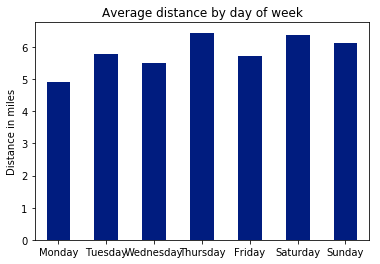

In [6]:
import calendar

trends.groupby('weekday').mean()['distance_mile'].plot(kind='bar')
plt.style.use('seaborn-dark-palette')
plt.xticks(list(range(7)), list(calendar.day_name),rotation='horizontal')
plt.xlabel('')
plt.ylabel('Distance in miles')
plt.title('Average distance by day of week')

Text(0.5,1,'Suffer score by day of week')

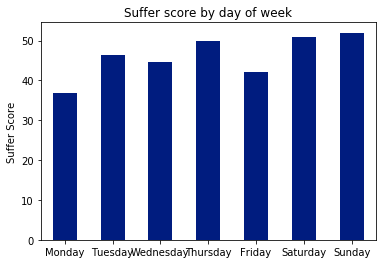

In [7]:
trends.groupby('weekday').mean()['suffer_score'].plot(kind='bar')
plt.style.use('seaborn-dark-palette')
plt.xticks(list(range(7)), list(calendar.day_name),rotation='horizontal')
plt.xlabel('')
plt.ylabel('Suffer Score')
plt.title('Suffer score by day of week')

Text(0.5,1,'Average pace by day of week')

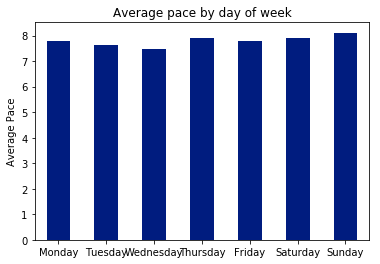

In [8]:
trends.groupby('weekday').mean()['average_pace'].plot(kind='bar')
plt.style.use('seaborn-dark-palette')
plt.xticks(list(range(7)), list(calendar.day_name),rotation='horizontal')
plt.xlabel('')
plt.ylabel('Average Pace')
plt.title('Average pace by day of week')

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


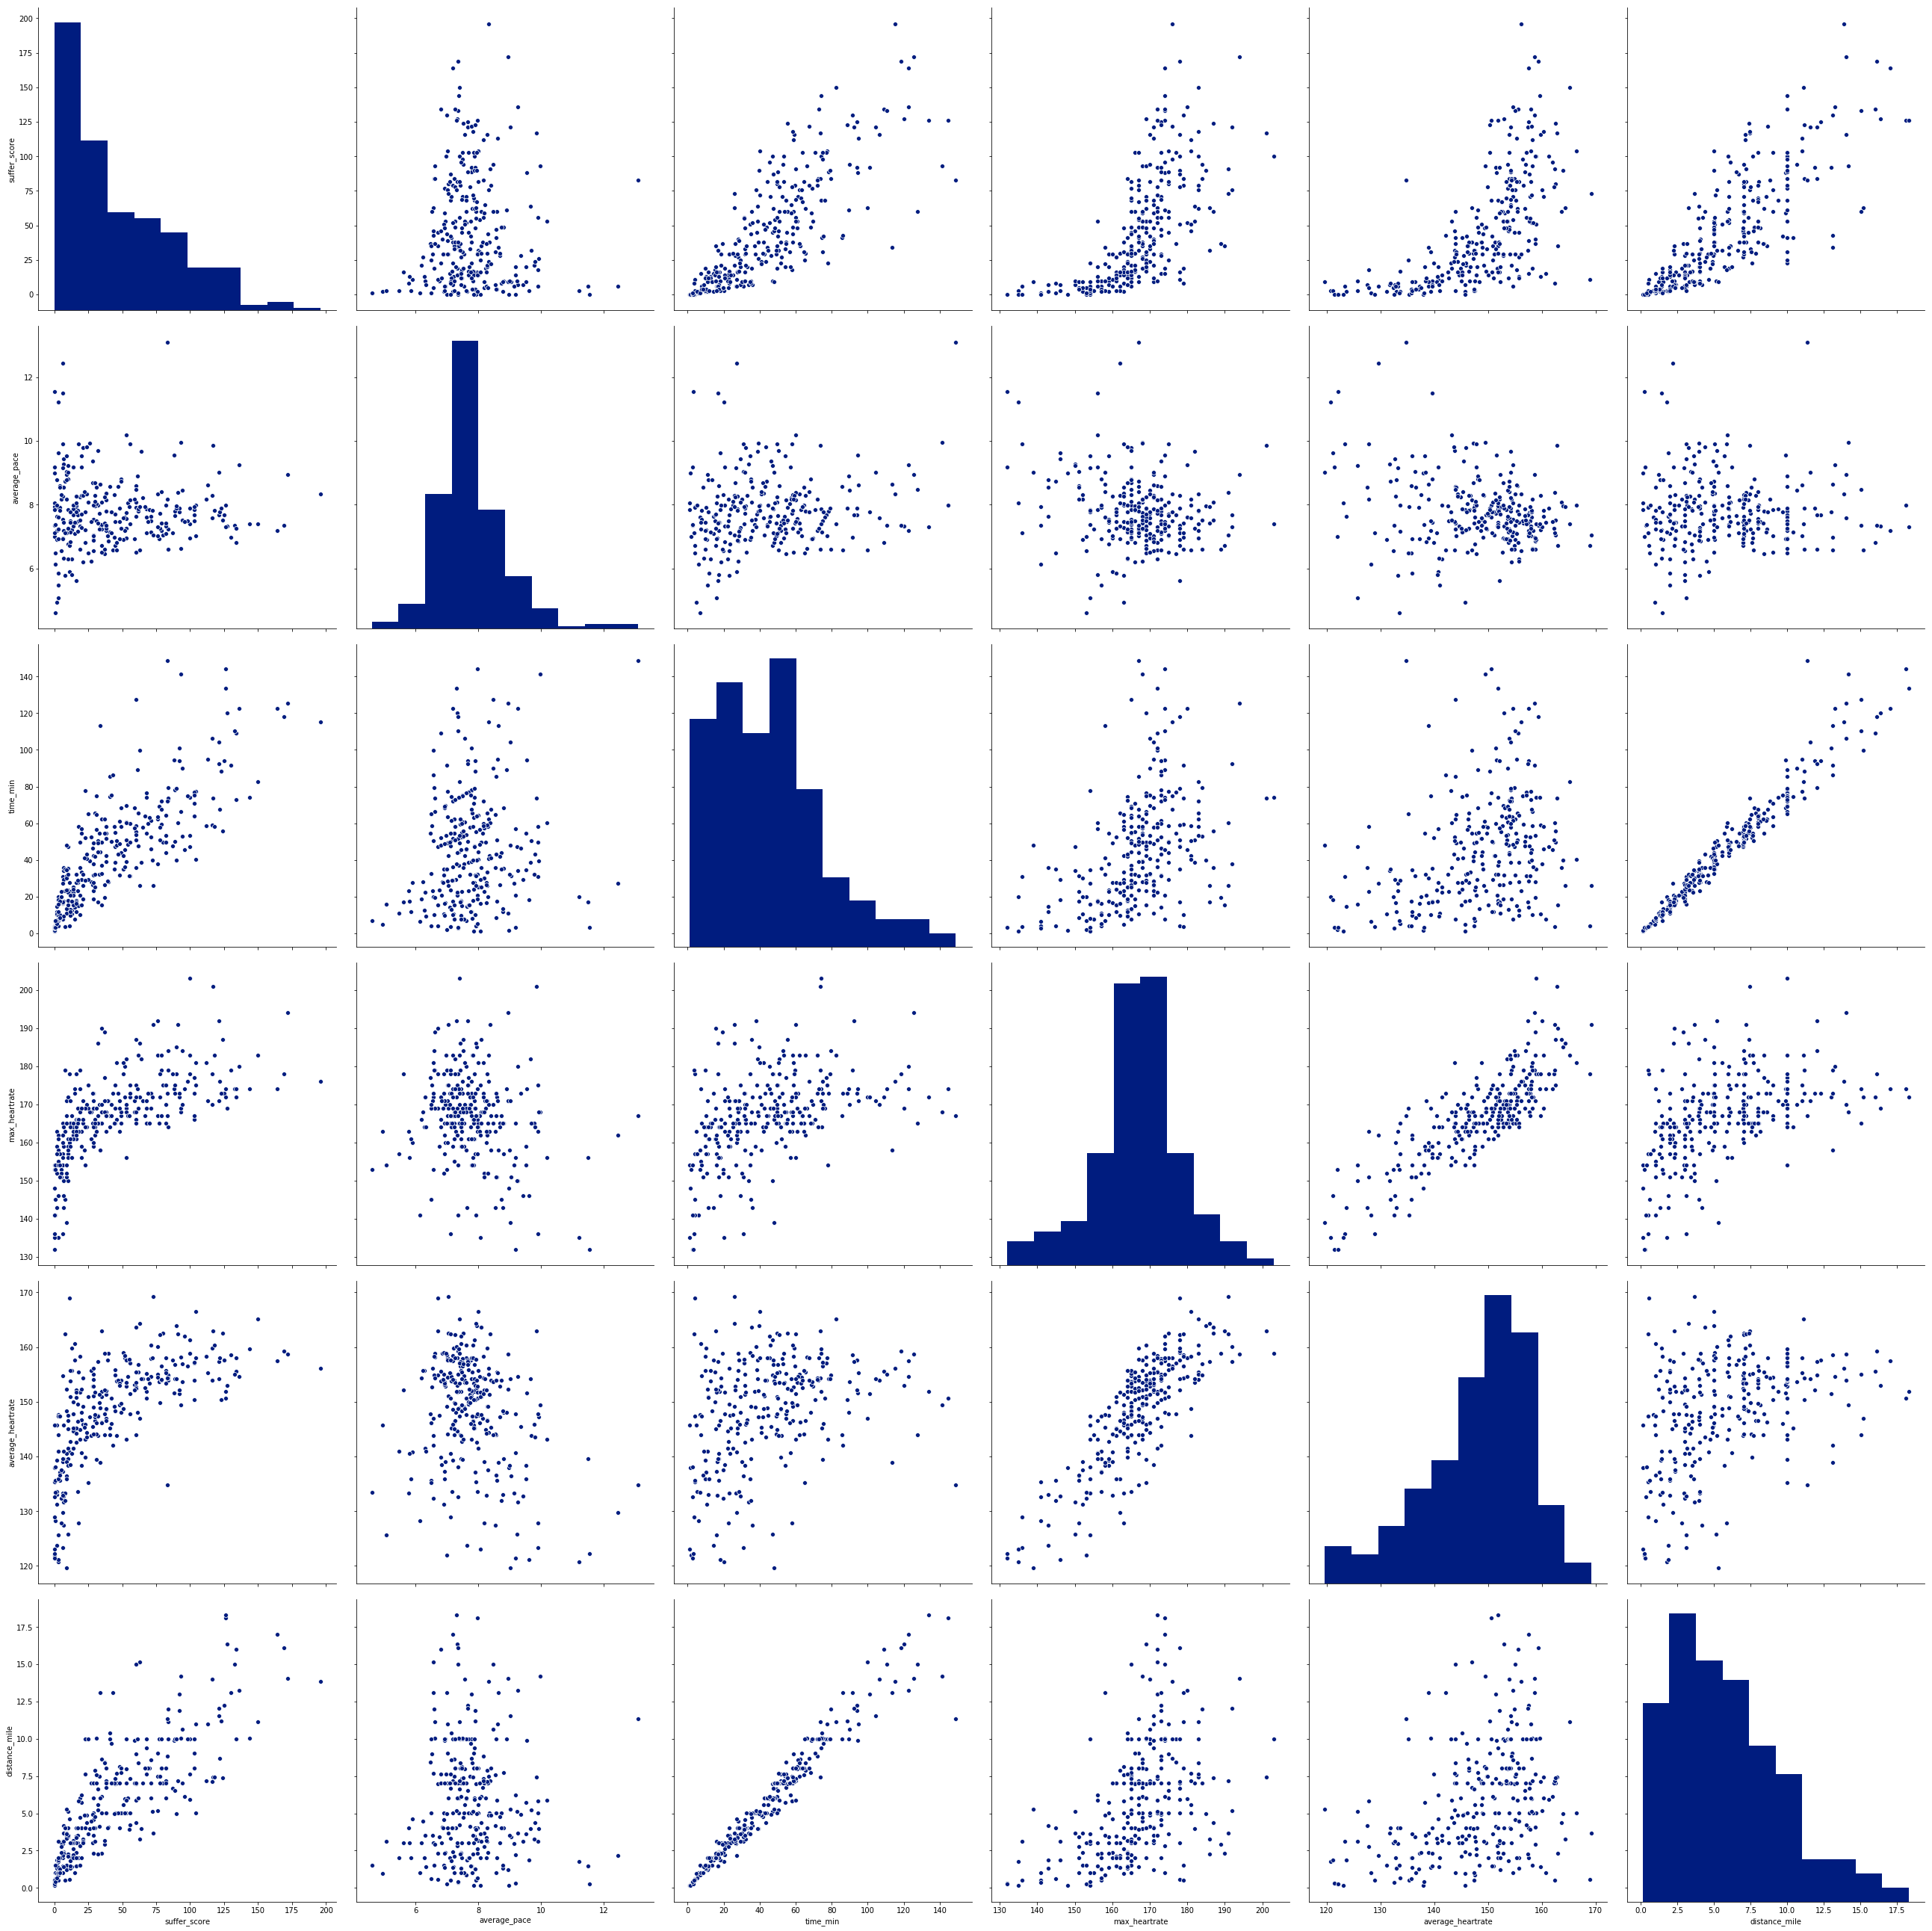

In [9]:
df.drop(['type'], axis = 1 , inplace = True)
del df['moving_time']
del df['distance']
df.head()
cols = ['suffer_score', 'average_pace', 'time_min', 'max_heartrate', 'average_heartrate', 'distance_mile']
sns.pairplot(x_vars=cols, y_vars = cols, data =df, size = 6)

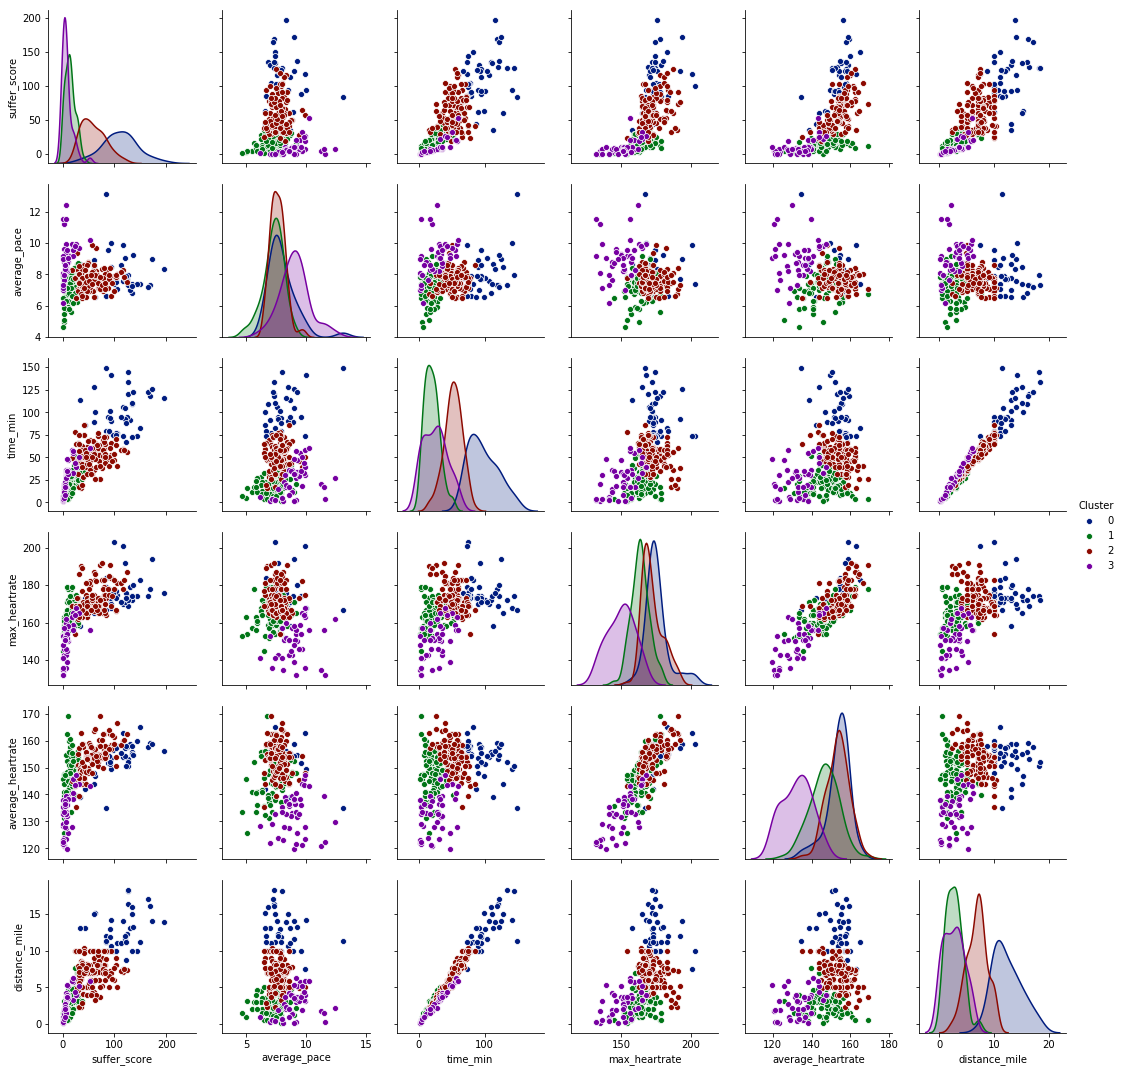

In [10]:
import sklearn
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df)

from sklearn.cluster import KMeans
model = KMeans(n_clusters = 4)
model.fit(X)
df['Cluster'] = model.labels_
sns.pairplot(x_vars=cols, y_vars=cols, hue = 'Cluster', data =df)